# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-05-09*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src/')
import ModelEvaLib as me

## 读取数据

In [2]:
isam = xr.open_dataset('F:/Data/case_anqing/April/April_ISAM1.nc')
isam

<xarray.Dataset>
Dimensions:    (time: 720, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-01 ... 2023-04-30T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    O3_AQ      (time, level, y, x) float32 ...
    O3_HF      (time, level, y, x) float32 ...
    O3_TL      (time, level, y, x) float32 ...
    O3_CZ      (time, level, y, x) float32 ...
    O3_JJ      (time, level, y, x) float32 ...
    O3_OTH     (time, level, y, x) float32 ...
    O3_ICO     (time, level, y, x) float32 ...
    O3_BCO     (time, level, y, x) float32 ...
Attributes:
    case:     Anqing_202304
    grid:     CN3AH_135X138

In [3]:
# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isam.O3_AQ, isam.O3_HF, isam.O3_TL, isam.O3_CZ, 
            isam.O3_JJ, isam.O3_OTH, isam.O3_ICO, isam.O3_BCO]
name_list = ['AQ', 'HF', 'TL', 'CZ', 'JJ', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    
    # 在 L2 字典中存储 L2 变量
    L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1 = L1_dict.values()
AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2 = L2_dict.values()

In [4]:
# 计算区域范围内的平均值
import geopandas as gpd

shpurban = 'F:/Data/case_anqing/shapefile/Anqing_urban/urban.shp'
shp = gpd.read_file(shpurban)

# 获取需要遍历的变量列表
var_list = [AQ_L1, HF_L1, TL_L1, CZ_L1, JJ_L1, OTH_L1, ICO_L1, BCO_L1, 
            AQ_L2, HF_L2, TL_L2, CZ_L2, JJ_L2, OTH_L2, ICO_L2, BCO_L2]

for i in range(np.size(isam.latitude,0)):
    for j in range(np.size(isam.latitude,1)):
        if me.polygon_to_mask(shp.geometry[0],isam.longitude[i,j],isam.latitude[i,j])==False:
            # 将所有需要置为 nan 的变量放到一个列表中，以便循环处理
            nan_var_list = [var[:,i,j] for var in var_list]
            
            # 循环将每个变量置为 nan
            for nan_var in nan_var_list:
                nan_var[:] = np.nan

calc_var_list = ['aq_L1', 'hf_L1', 'tl_L1', 'cz_L1', 'jj_L1', 'oth_L1', 'ico_L1', 'bco_L1',
                 'aq_L2', 'hf_L2', 'tl_L2', 'cz_L2', 'jj_L2', 'oth_L2', 'ico_L2', 'bco_L2']

for i, var in enumerate(var_list):
    # 计算变量的均值
    var_mean = np.nanmean(np.nanmean(var,1),1)
    
    # 将变量均值赋值回原始变量
    exec(f"{calc_var_list[i]} = var_mean")

aq_L1.shape

(720,)

In [5]:
all_L1 = aq_L1+hf_L1+tl_L1+cz_L1+jj_L1+oth_L1+ico_L1+bco_L1
all_L2 = aq_L2+hf_L2+tl_L2+cz_L2+jj_L2+oth_L2+ico_L2+bco_L2

# 设定变量名称循环列表
names = ['aq', 'hf', 'tl', 'cz', 'jj', 'oth', 'ico', 'bco']

# 计算ratio
ratio_L1 = {}
ratio_L2 = {}
for name in names:
    var_L1 = f"{name}_L1"
    var_L2 = f"{name}_L2"
    ratio_L1[f"{var_L1}_rt"] = globals()[var_L1] / all_L1
    ratio_L2[f"{var_L2}_rt"] = globals()[var_L2] / all_L2
    
aq_L1_rt, hf_L1_rt, tl_L1_rt, cz_L1_rt, jj_L1_rt, oth_L1_rt, ico_L1_rt, bco_L1_rt = ratio_L1.values()
aq_L2_rt, hf_L2_rt, tl_L2_rt, cz_L2_rt, jj_L2_rt, oth_L2_rt, ico_L2_rt, bco_L2_rt = ratio_L2.values()

In [9]:
timeindex = pd.date_range('2023-04-01T00','2023-04-30T23',freq='h')
df_L1 = pd.DataFrame(
    index=timeindex,
    data={'aq':aq_L1_rt,'hf':hf_L1_rt,'tl':tl_L1_rt,'cz':cz_L1_rt,
          'jj':jj_L1_rt,'oth':oth_L1_rt,'bco':bco_L1_rt,'ico':ico_L1_rt}
    )
df_L2 = pd.DataFrame(
    index=timeindex,
    data={'aq':aq_L2_rt,'hf':hf_L2_rt,'tl':tl_L2_rt,'cz':cz_L2_rt,
          'jj':jj_L2_rt,'oth':oth_L2_rt,'bco':bco_L2_rt,'ico':ico_L2_rt}
    )

In [22]:
# 取日间时刻数据

df_L1_day = df_L1.loc[df_L1.index.hour.isin(np.arange(6,18))]
df_L2_day = df_L2.loc[df_L2.index.hour.isin(np.arange(6,18))]

## 画图

`Ratio`全时长`L1`

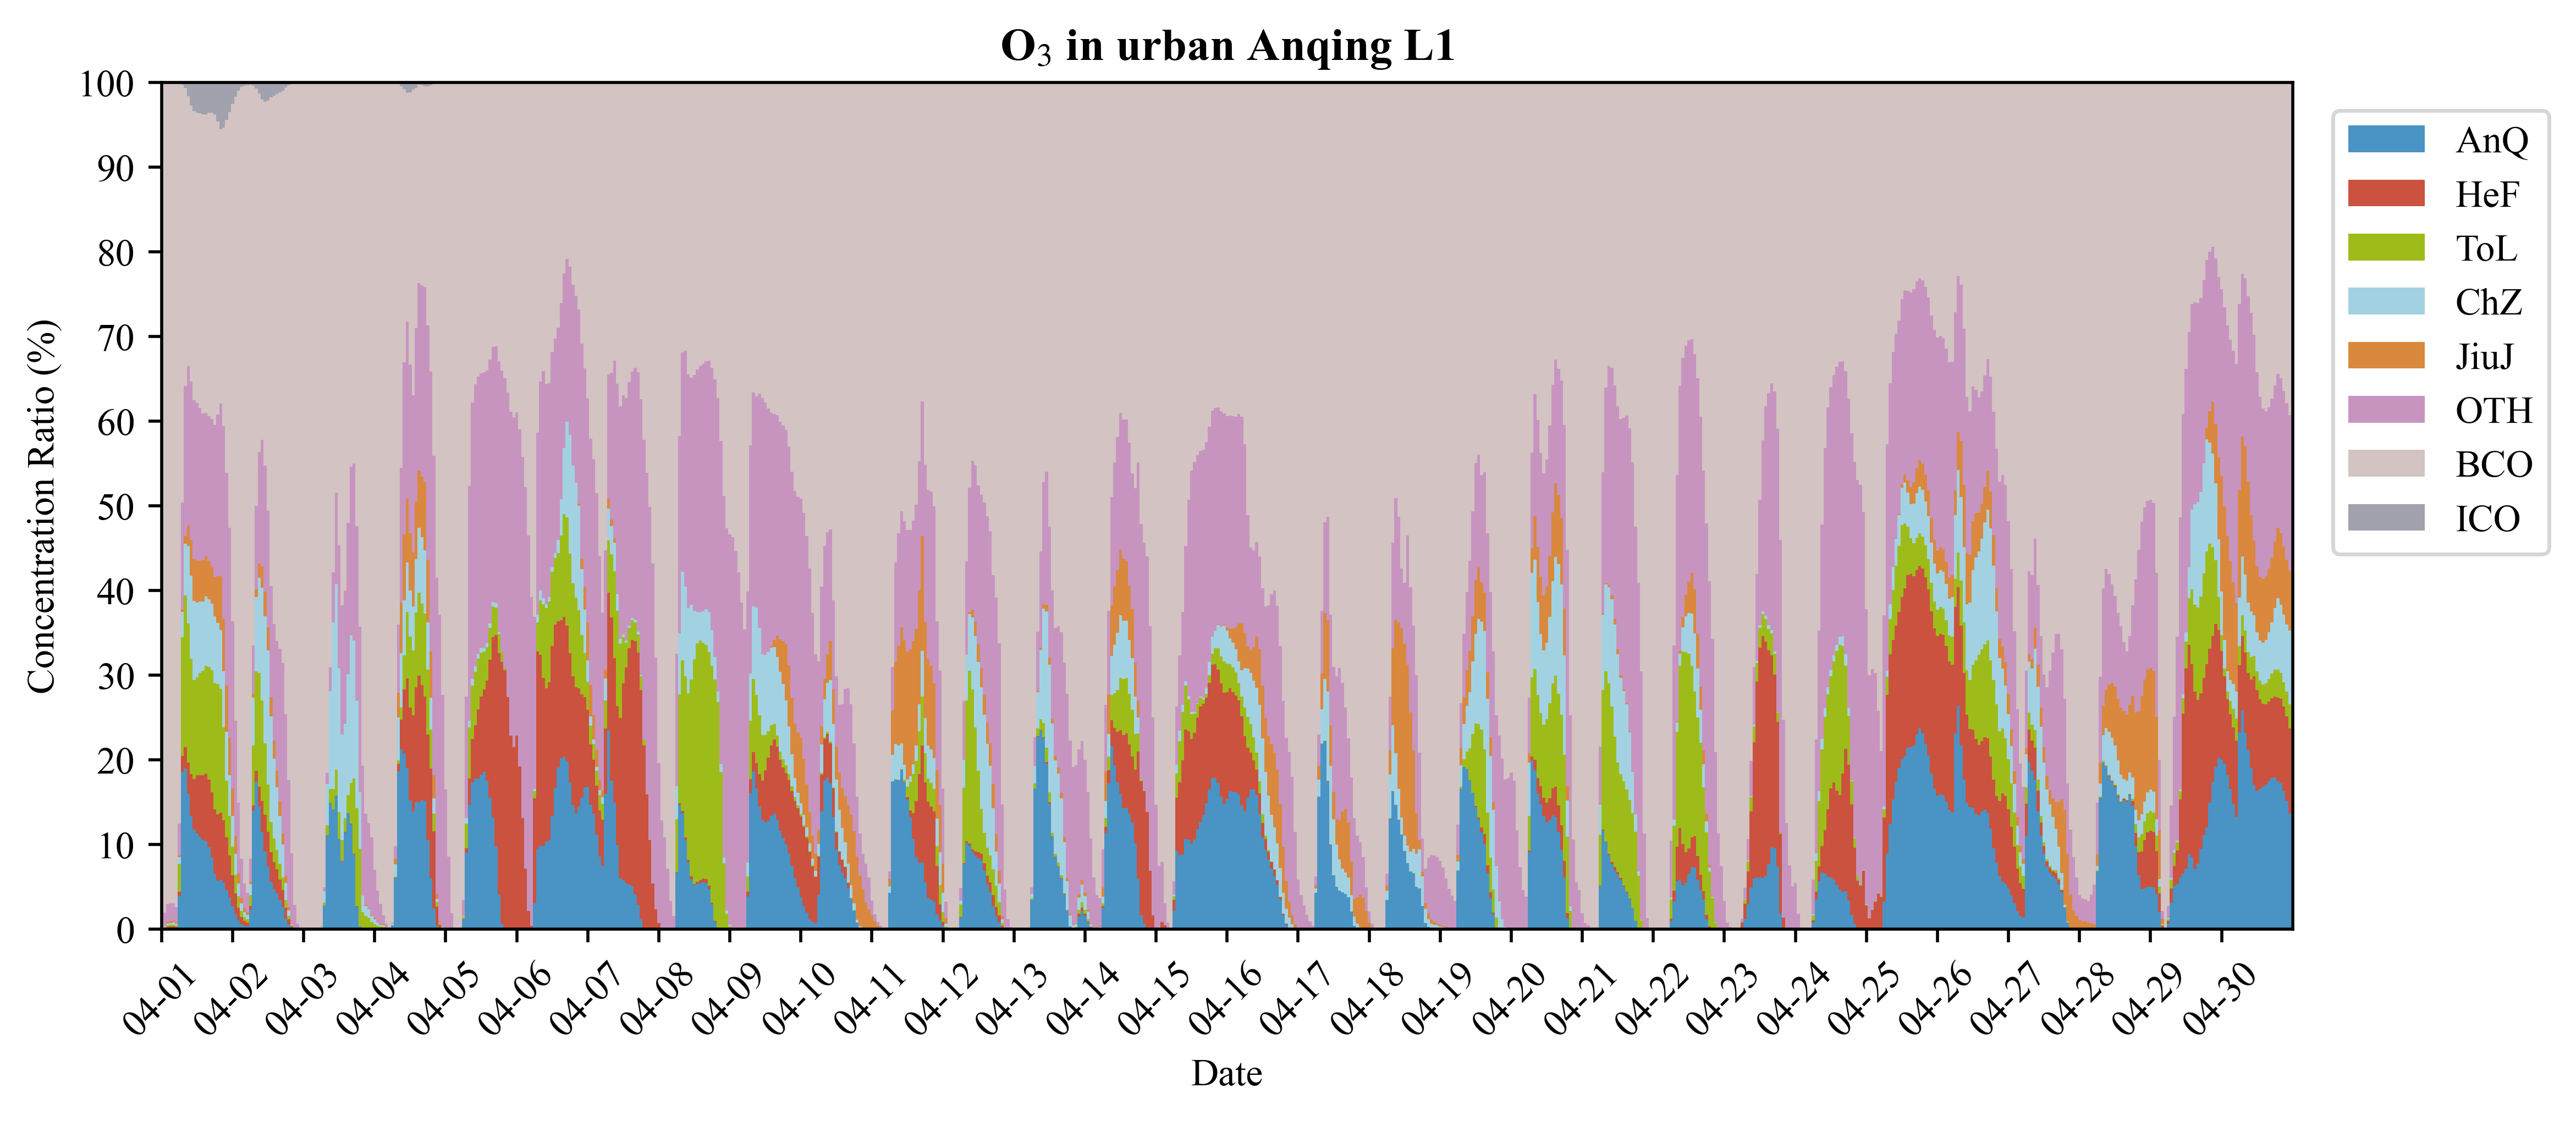

In [25]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L1_rt,color=coloraq,width=1)
b2=ax.bar(ts,hf_L1_rt,bottom=aq_L1_rt,color=colorhf,width=1)
b3=ax.bar(ts,tl_L1_rt,bottom=hf_L1_rt+aq_L1_rt,color=colortl,width=1)
b4=ax.bar(ts,cz_L1_rt,bottom=tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorcz,width=1)
b5=ax.bar(ts,jj_L1_rt,bottom=cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorjj,width=1)
b6=ax.bar(ts,oth_L1_rt,bottom=jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L1_rt,bottom=oth_L1_rt+jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L1_rt,bottom=bco_L1_rt+oth_L1_rt+jj_L1_rt+cz_L1_rt+tl_L1_rt+hf_L1_rt+aq_L1_rt,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ in urban Anqing L1',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration Ratio (%)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,1)
ax.set_xlim(0,720)

plt.show()

`Ratio`日间时长`L1`

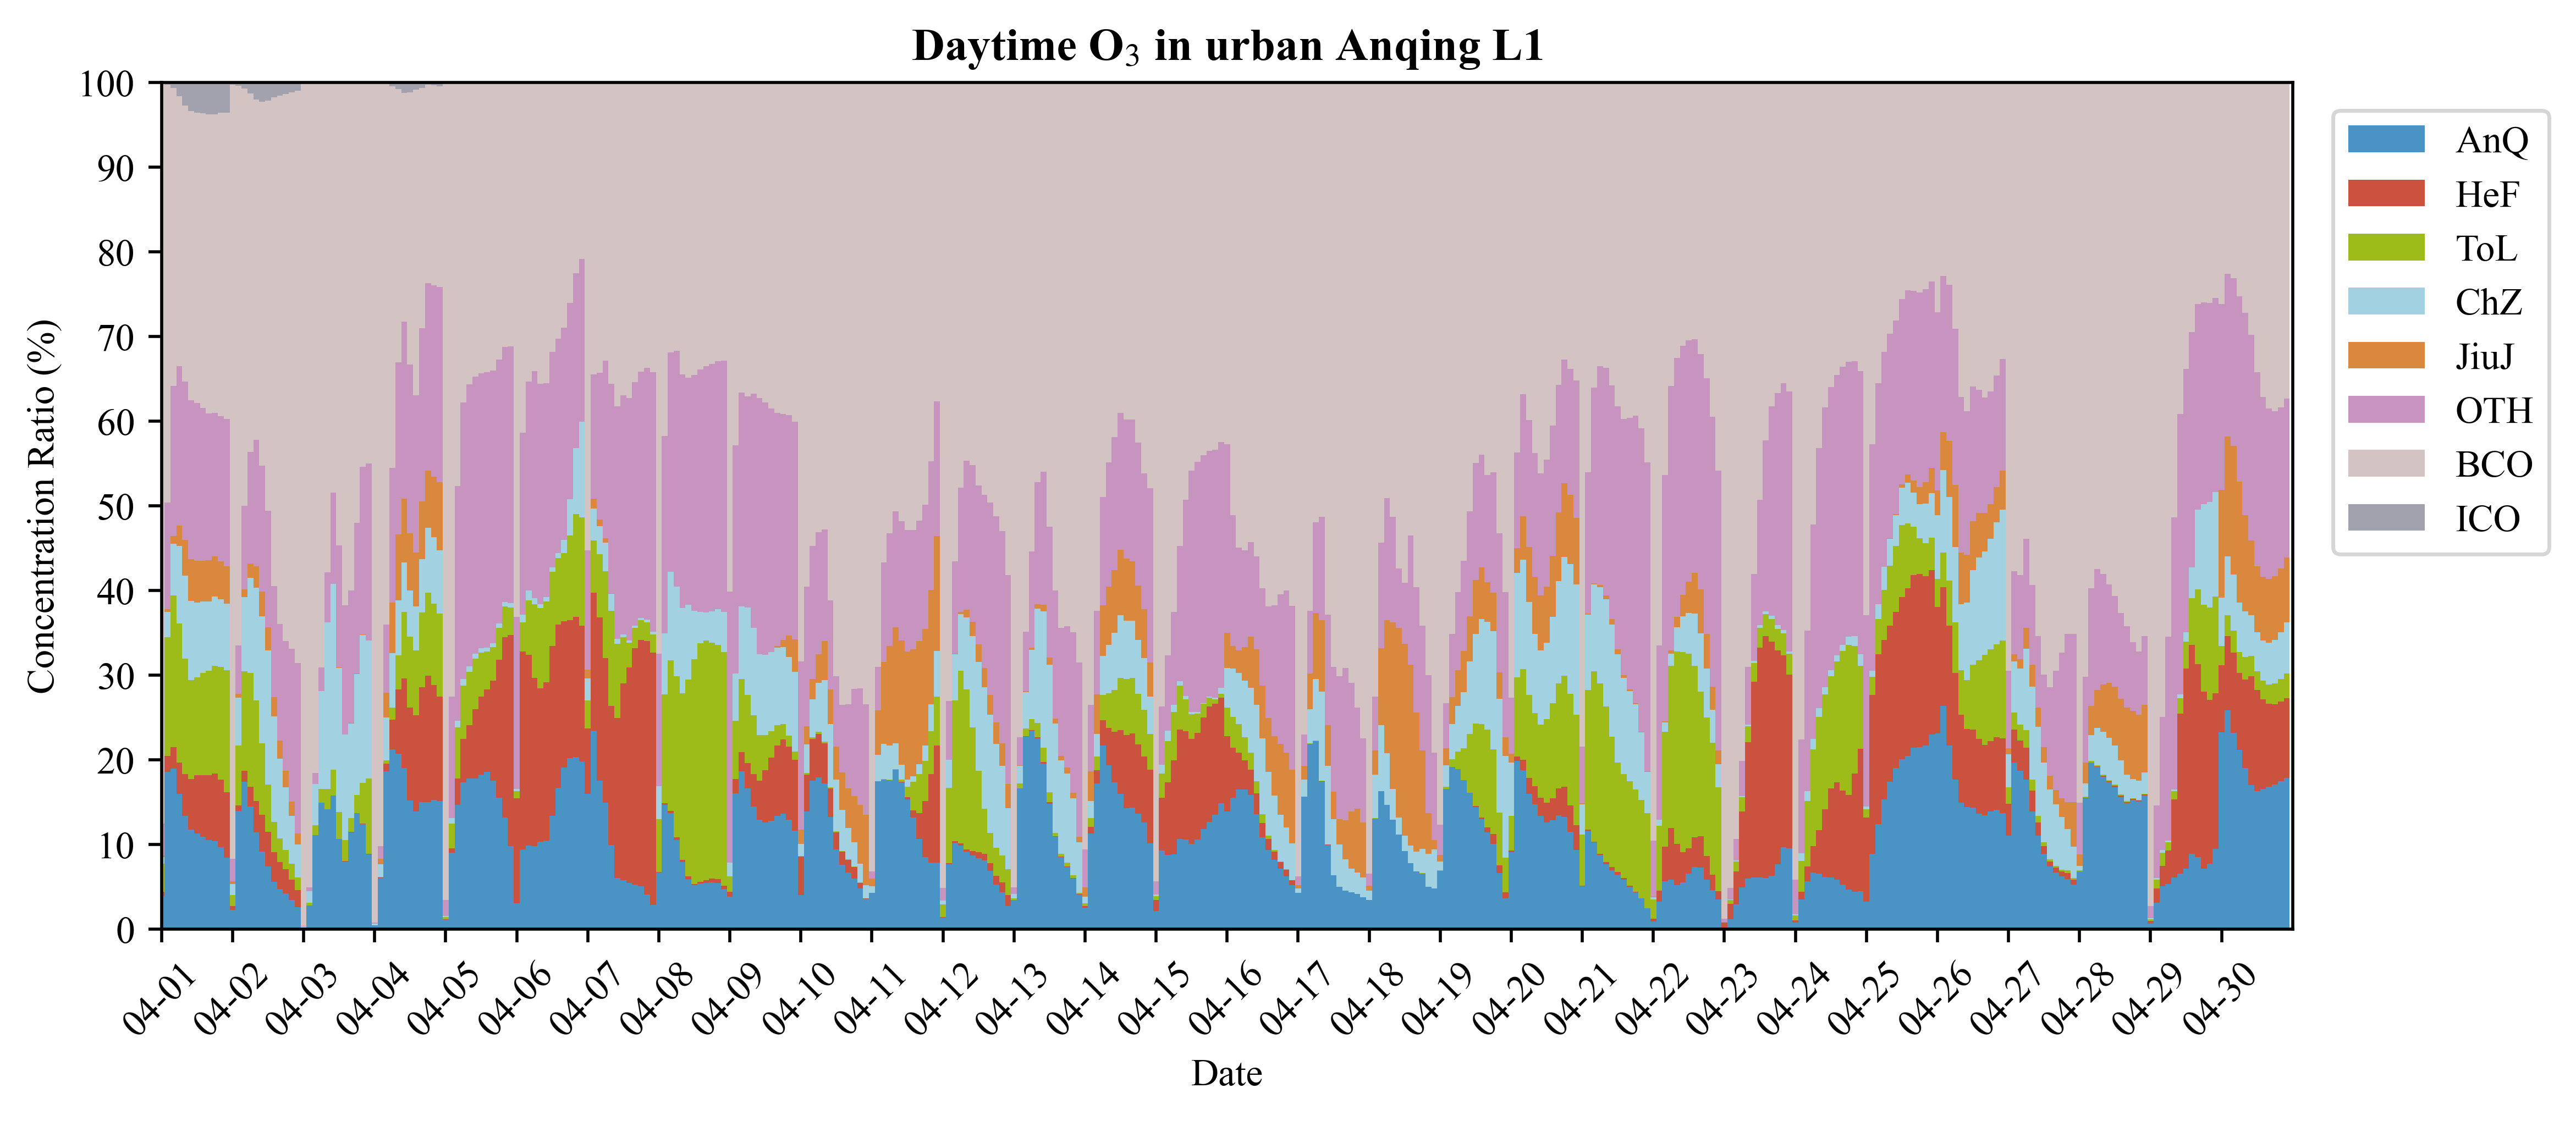

In [24]:
ts=np.arange(0,360)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,df_L1_day['aq'],color=coloraq,width=1)
b2=ax.bar(ts,df_L1_day['hf'],bottom=df_L1_day['aq'],color=colorhf,width=1)
b3=ax.bar(ts,df_L1_day['tl'],bottom=df_L1_day['hf']+df_L1_day['aq'],color=colortl,width=1)
b4=ax.bar(ts,df_L1_day['cz'],bottom=df_L1_day['tl']+df_L1_day['hf']+df_L1_day['aq'],color=colorcz,width=1)
b5=ax.bar(ts,df_L1_day['jj'],bottom=df_L1_day['cz']+df_L1_day['tl']+df_L1_day['hf']+df_L1_day['aq'],color=colorjj,width=1)
b6=ax.bar(ts,df_L1_day['oth'],bottom=df_L1_day['jj']+df_L1_day['cz']+df_L1_day['tl']+df_L1_day['hf']+df_L1_day['aq'],color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,df_L1_day['bco'],bottom=df_L1_day['oth']+df_L1_day['jj']+df_L1_day['cz']+df_L1_day['tl']+df_L1_day['hf']+df_L1_day['aq'],color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,df_L1_day['ico'],bottom=df_L1_day['bco']+df_L1_day['oth']+df_L1_day['jj']+df_L1_day['cz']+df_L1_day['tl']+df_L1_day['hf']+df_L1_day['aq'],color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('Daytime O$_3$ in urban Anqing L1',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration Ratio (%)')
ax.set_xticks(np.arange(0,360,12))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,1)
ax.set_xlim(0,360)

plt.show()

`Abso`全时长`L1`

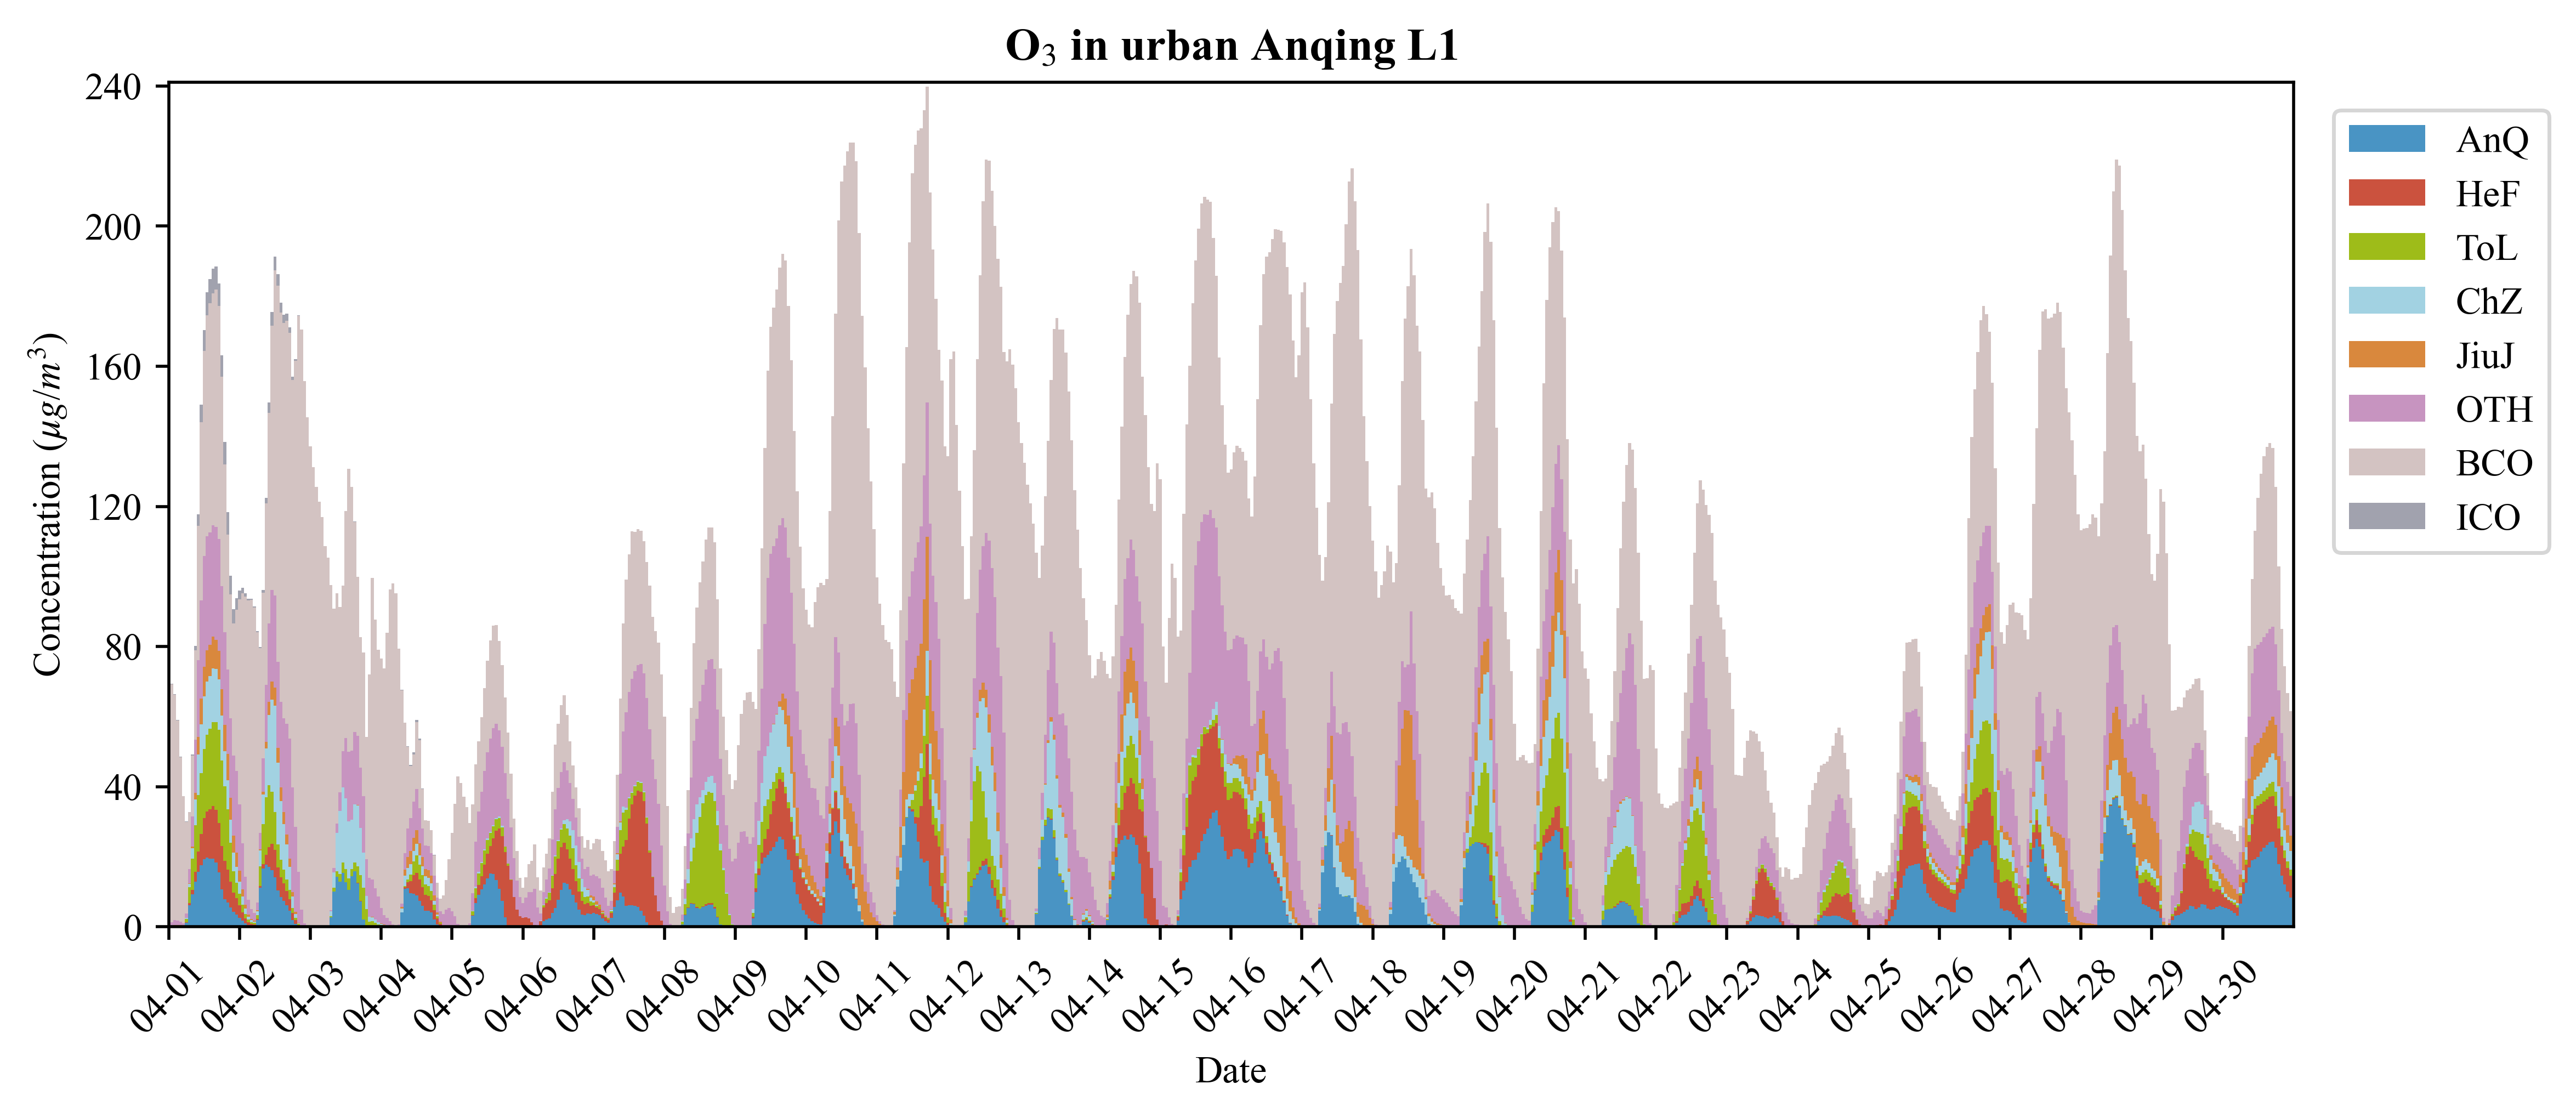

In [26]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L1,color=coloraq,width=1)
b2=ax.bar(ts,hf_L1,bottom=aq_L1,color=colorhf,width=1)
b3=ax.bar(ts,tl_L1,bottom=hf_L1+aq_L1,color=colortl,width=1)
b4=ax.bar(ts,cz_L1,bottom=tl_L1+hf_L1+aq_L1,color=colorcz,width=1)
b5=ax.bar(ts,jj_L1,bottom=cz_L1+tl_L1+hf_L1+aq_L1,color=colorjj,width=1)
b6=ax.bar(ts,oth_L1,bottom=jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L1,bottom=oth_L1+jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L1,bottom=bco_L1+oth_L1+jj_L1+cz_L1+tl_L1+hf_L1+aq_L1,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ in urban Anqing L1',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,241,40))
# ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,241)
ax.set_xlim(0,720)

plt.show()

`Ratio`全时长`L2`

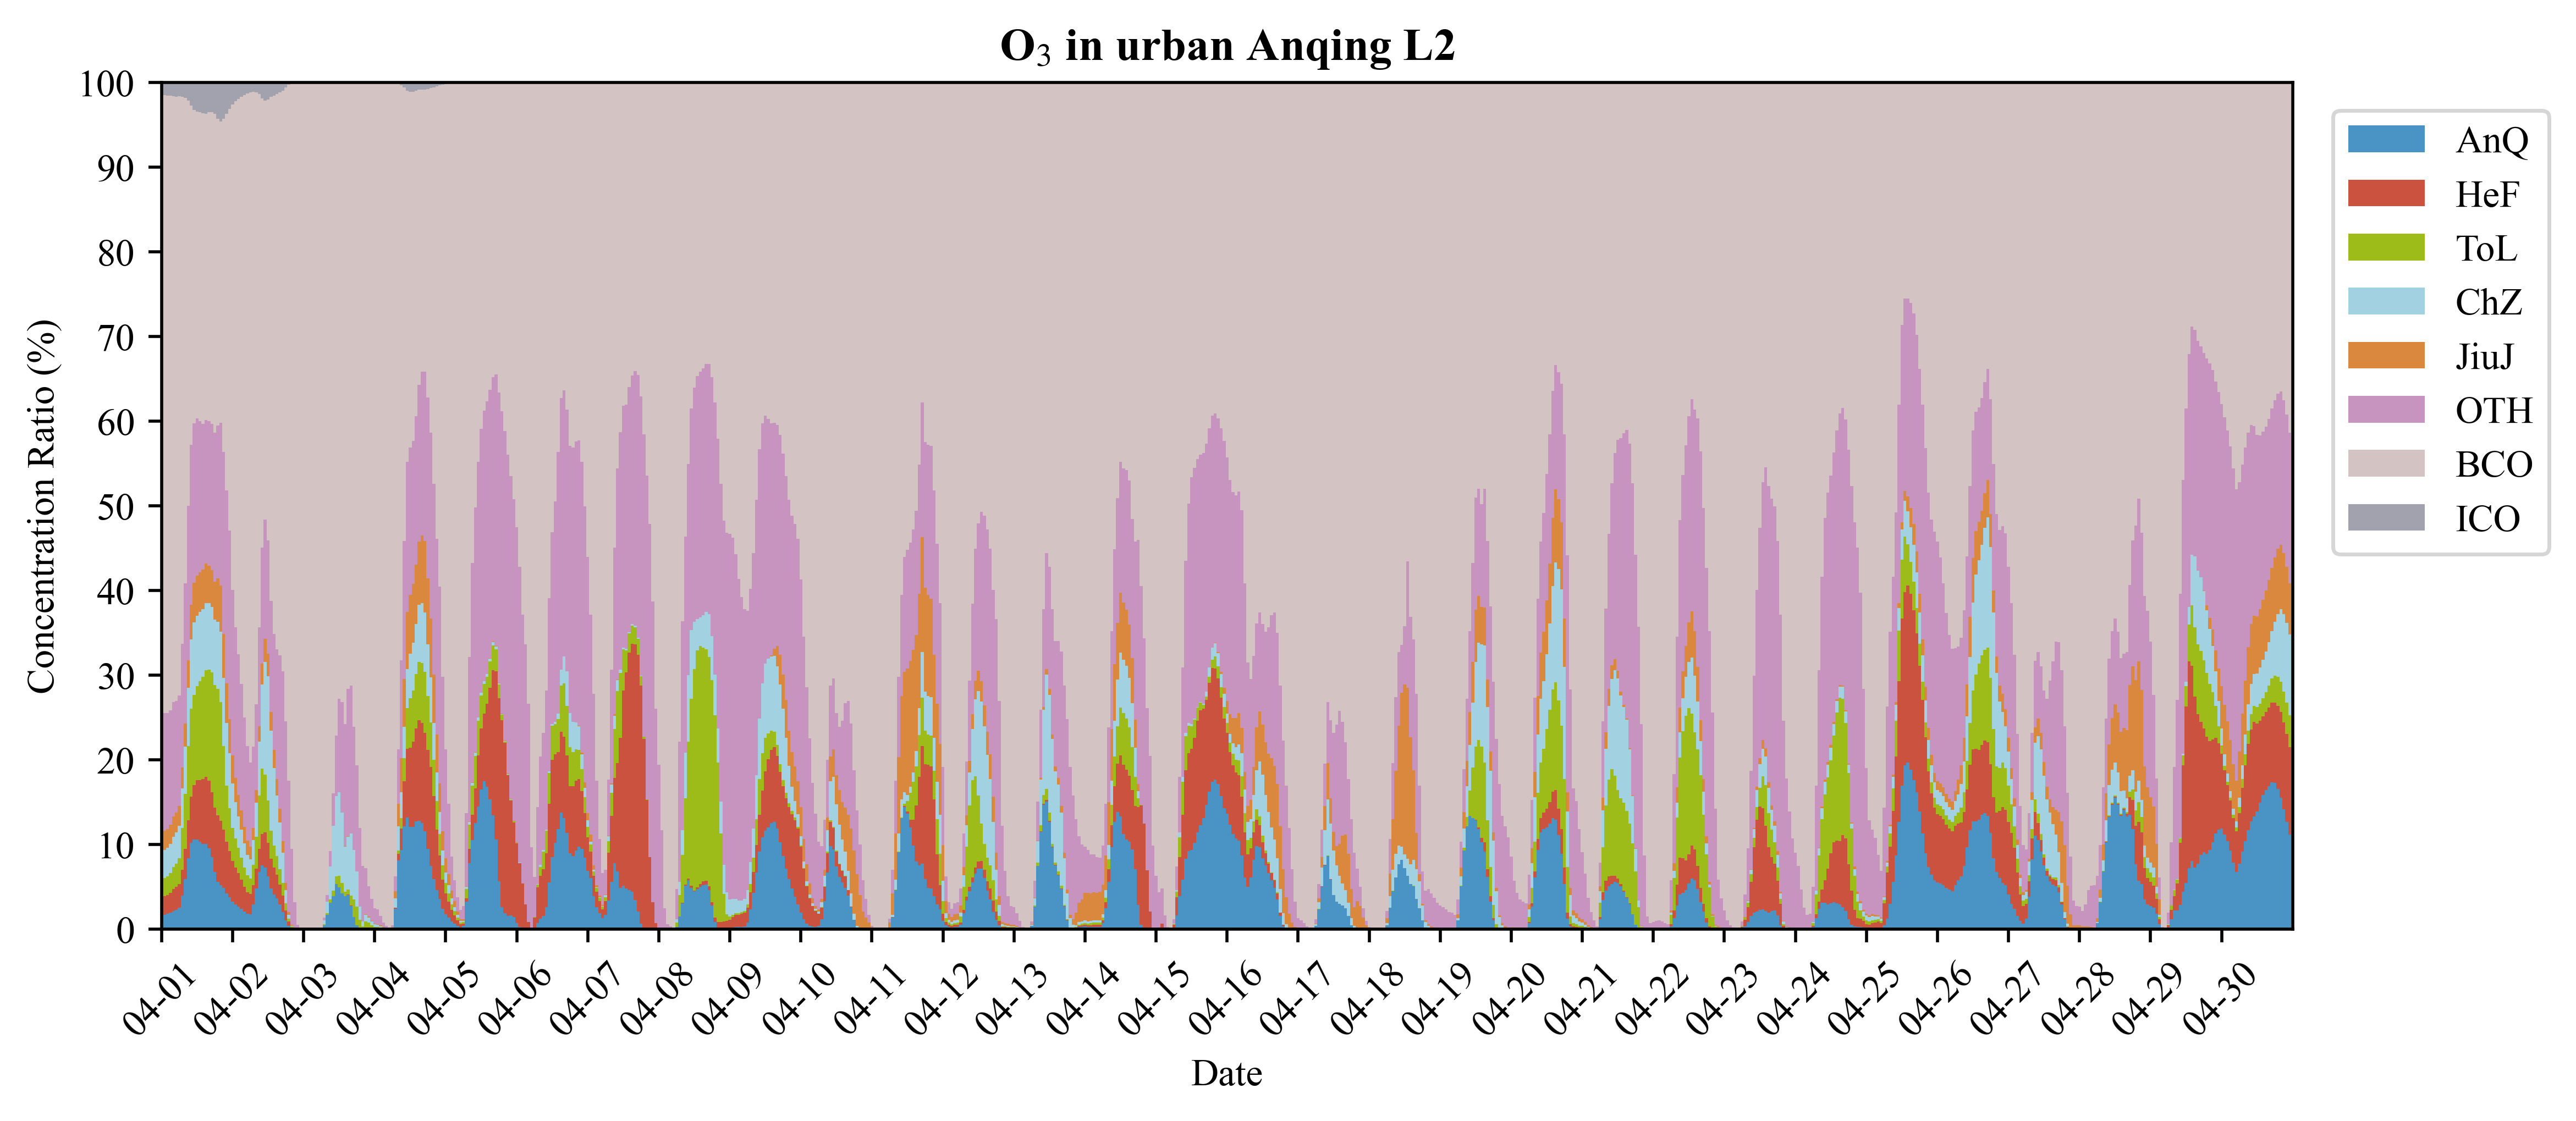

In [27]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L2_rt,color=coloraq,width=1)
b2=ax.bar(ts,hf_L2_rt,bottom=aq_L2_rt,color=colorhf,width=1)
b3=ax.bar(ts,tl_L2_rt,bottom=hf_L2_rt+aq_L2_rt,color=colortl,width=1)
b4=ax.bar(ts,cz_L2_rt,bottom=tl_L2_rt+hf_L2_rt+aq_L2_rt,color=colorcz,width=1)
b5=ax.bar(ts,jj_L2_rt,bottom=cz_L2_rt+tl_L2_rt+hf_L2_rt+aq_L2_rt,color=colorjj,width=1)
b6=ax.bar(ts,oth_L2_rt,bottom=jj_L2_rt+cz_L2_rt+tl_L2_rt+hf_L2_rt+aq_L2_rt,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L2_rt,bottom=oth_L2_rt+jj_L2_rt+cz_L2_rt+tl_L2_rt+hf_L2_rt+aq_L2_rt,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L2_rt,bottom=bco_L2_rt+oth_L2_rt+jj_L2_rt+cz_L2_rt+tl_L2_rt+hf_L2_rt+aq_L2_rt,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ in urban Anqing L2',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration Ratio (%)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,1)
ax.set_xlim(0,720)

plt.show()

`Abso`全时长`L2`

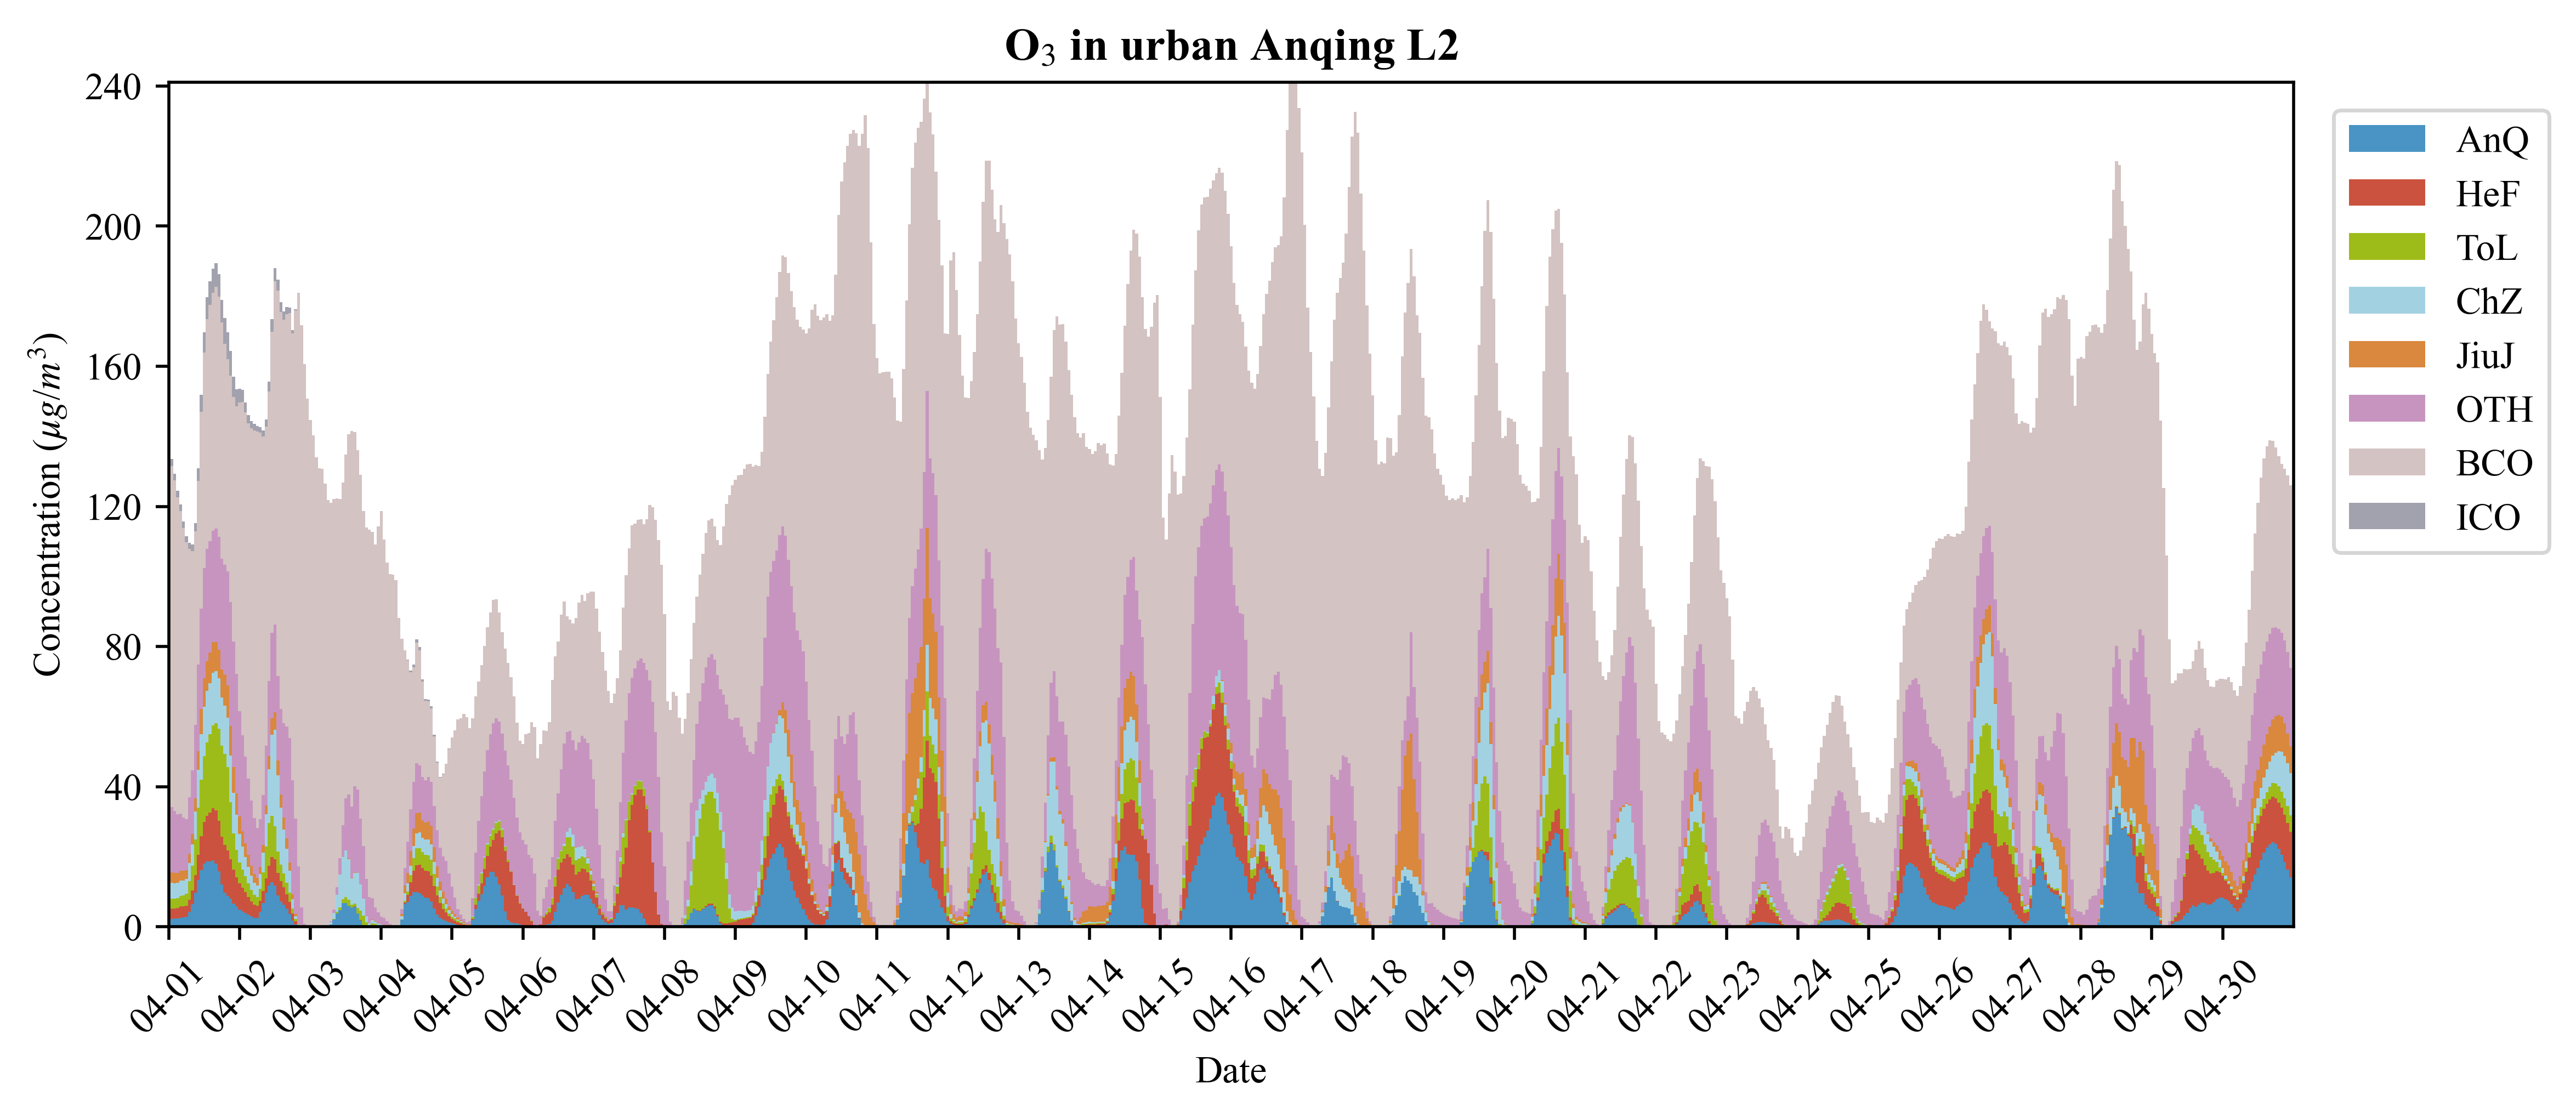

In [28]:
ts=np.arange(0,720)

coloraq='#4994c4'
colorhf='#cb523e'
colortl='#9ebc19'
colorcz='#a2d2e2'
colorjj='#d9883d'
coloroth='#ba79b1'
colorbco='#c8b5b3'
colorico='#45465e'

fig,ax =plt.subplots(figsize=(10,4),dpi=500)
b1=ax.bar(ts,aq_L2,color=coloraq,width=1)
b2=ax.bar(ts,hf_L2,bottom=aq_L2,color=colorhf,width=1)
b3=ax.bar(ts,tl_L2,bottom=hf_L2+aq_L2,color=colortl,width=1)
b4=ax.bar(ts,cz_L2,bottom=tl_L2+hf_L2+aq_L2,color=colorcz,width=1)
b5=ax.bar(ts,jj_L2,bottom=cz_L2+tl_L2+hf_L2+aq_L2,color=colorjj,width=1)
b6=ax.bar(ts,oth_L2,bottom=jj_L2+cz_L2+tl_L2+hf_L2+aq_L2,color=coloroth,width=1,alpha=0.8)
b7=ax.bar(ts,bco_L2,bottom=oth_L2+jj_L2+cz_L2+tl_L2+hf_L2+aq_L2,color=colorbco,width=1,alpha=0.8)
b8=ax.bar(ts,ico_L2,bottom=bco_L2+oth_L2+jj_L2+cz_L2+tl_L2+hf_L2+aq_L2,color=colorico,width=1,alpha=0.5)

ax.legend((b1[0],b2[0],b3[0],b4[0],b5[0],b6[0],b7[0],b8[0]),
          ('AnQ','HeF','ToL','ChZ','JiuJ','OTH','BCO','ICO'),bbox_to_anchor=(1.01,0.99))
ax.set_title('O$_3$ in urban Anqing L2',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2023-04-01','2023-04-30',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,241,40))
# ax.set_yticklabels(np.arange(0,101,10))
ax.set_ylim(0,241)
ax.set_xlim(0,720)

plt.show()

统计数据

In [42]:
print('REGION', 'MEAN', 'MIN', 'MAX')
print('Anqing',np.mean(aq_L1_rt).round(2),np.min(aq_L1_rt).round(2),np.max(aq_L1_rt).round(2))
print('Anqing',np.mean(aq_L1).round(2),np.min(aq_L1).round(2),np.max(aq_L1).round(2))

print('Hefei',np.mean(hf_L1_rt).round(2),np.min(hf_L1_rt).round(2),np.max(hf_L1_rt).round(2))
print('Hefei',np.mean(hf_L1).round(2),np.min(hf_L1).round(2),np.max(hf_L1).round(2))

print('Tongl',np.mean(tl_L1_rt).round(2),np.min(tl_L1_rt).round(2),np.max(tl_L1_rt).round(2))
print('Tongl',np.mean(tl_L1).round(2),np.min(tl_L1).round(2),np.max(tl_L1).round(2))

print('Chizh',np.mean(cz_L1_rt).round(2),np.min(cz_L1_rt).round(2),np.max(cz_L1_rt).round(2))
print('Chizh',np.mean(cz_L1).round(2),np.min(cz_L1).round(2),np.max(cz_L1).round(2))

print('Jiuji',np.mean(jj_L1_rt).round(2),np.min(jj_L1_rt).round(2),np.max(jj_L1_rt).round(2))
print('Jiuji',np.mean(jj_L1).round(2),np.min(jj_L1).round(2),np.max(jj_L1).round(2))

print('OTHER',np.mean(oth_L1_rt).round(2),np.min(oth_L1_rt).round(2),np.max(oth_L1_rt).round(2))
print('OTHER',np.mean(oth_L1).round(2),np.min(oth_L1).round(2),np.max(oth_L1).round(2))

print('BCON',np.mean(bco_L1_rt).round(2),np.min(bco_L1_rt).round(2),np.max(bco_L1_rt).round(2))
print('BCON',np.mean(bco_L1).round(2),np.min(bco_L1).round(2),np.max(bco_L1).round(2))

print('ICON',np.mean(ico_L1_rt).round(2),np.min(ico_L1_rt).round(2),np.max(ico_L1_rt).round(2))
print('ICON',np.mean(ico_L1).round(2),np.min(ico_L1).round(2),np.max(ico_L1).round(2))

REGION MEAN MIN MAX
Anqing 0.07 0.0 0.26
Anqing 7.91 0.0 36.81
Hefei 0.05 0.0 0.31
Hefei 4.41 0.0 33.85
Tongl 0.04 0.0 0.28
Tongl 3.78 0.0 31.78
Chizh 0.04 0.0 0.22
Chizh 4.53 0.0 31.44
Jiuji 0.03 0.0 0.23
Jiuji 3.44 0.0 41.43
OTHER 0.17 0.0 0.47
OTHER 16.33 0.0 60.77
BCON 0.6 0.19 1.0
BCON 62.52 3.33 176.44
ICON 0.0 0.0 0.05
ICON 0.16 0.0 7.08


In [29]:
print('REGION', 'MEAN', 'MIN', 'MAX')
print('Anqing',np.mean(aq_L2_rt).round(2),np.min(aq_L2_rt).round(2),np.max(aq_L2_rt).round(2))
print('Anqing',np.mean(aq_L2).round(2),np.min(aq_L2).round(2),np.max(aq_L2).round(2))

print('Hefei',np.mean(hf_L2_rt).round(2),np.min(hf_L2_rt).round(2),np.max(hf_L2_rt).round(2))
print('Hefei',np.mean(hf_L2).round(2),np.min(hf_L2).round(2),np.max(hf_L2).round(2))

print('Tongl',np.mean(tl_L2_rt).round(2),np.min(tl_L2_rt).round(2),np.max(tl_L2_rt).round(2))
print('Tongl',np.mean(tl_L2).round(2),np.min(tl_L2).round(2),np.max(tl_L2).round(2))

print('Chizh',np.mean(cz_L2_rt).round(2),np.min(cz_L2_rt).round(2),np.max(cz_L2_rt).round(2))
print('Chizh',np.mean(cz_L2).round(2),np.min(cz_L2).round(2),np.max(cz_L2).round(2))

print('Jiuji',np.mean(jj_L2_rt).round(2),np.min(jj_L2_rt).round(2),np.max(jj_L2_rt).round(2))
print('Jiuji',np.mean(jj_L2).round(2),np.min(jj_L2).round(2),np.max(jj_L2).round(2))

print('OTHER',np.mean(oth_L2_rt).round(2),np.min(oth_L2_rt).round(2),np.max(oth_L2_rt).round(2))
print('OTHER',np.mean(oth_L2).round(2),np.min(oth_L2).round(2),np.max(oth_L2).round(2))

print('BCON',np.mean(bco_L2_rt).round(2),np.min(bco_L2_rt).round(2),np.max(bco_L2_rt).round(2))
print('BCON',np.mean(bco_L2).round(2),np.min(bco_L2).round(2),np.max(bco_L2).round(2))

print('ICON',np.mean(ico_L2_rt).round(2),np.min(ico_L2_rt).round(2),np.max(ico_L2_rt).round(2))
print('ICON',np.mean(ico_L2).round(2),np.min(ico_L2).round(2),np.max(ico_L2).round(2))

REGION MEAN MIN MAX
Anqing 0.05 0.0 0.2
Anqing 6.6 0.0 38.32
Hefei 0.04 0.0 0.3
Hefei 4.84 0.0 35.1
Tongl 0.03 0.0 0.28
Tongl 3.51 0.0 31.99
Chizh 0.03 0.0 0.16
Chizh 4.35 0.0 31.54
Jiuji 0.02 0.0 0.2
Jiuji 3.57 0.0 39.03
OTHER 0.16 0.0 0.43
OTHER 19.72 0.0 61.73
BCON 0.67 0.25 1.0
BCON 88.02 15.53 228.4
ICON 0.0 0.0 0.05
ICON 0.22 0.0 7.75
